# Sætter partier og regioner ind i G og rewriter filen

In [1]:
import networkx as nx
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import re
from fa2 import ForceAtlas2


In [2]:
data=pd.read_csv("danish_politkere_twitter2.csv")

In [3]:
data.groupby('Party').count()

,Names,Twittername,Region
Party,,,
Alternativet,4,4,4
Dansk Folkeparti,21,21,21
Det Konservative Folkeparti,22,22,22
Det Radikale Venstre,1,1,1
Enhedslisten,23,23,23
Government,14,14,14
Inuit Ataqatigiit,1,1,1
Liberal Alliance,7,7,7
Nye Borgerlige,4,4,4


In [4]:
len(data.index)

651

In [5]:
G = nx.read_gpickle("second_network_w_weights_listversion_wrealnames_v2.gpickle")

In [6]:
G.number_of_nodes()

561

In [7]:
def pre_check():
    nodes = G.nodes()
    count=0
    to_remove = [] 
    for node in nodes:
        if node in data.values:
            count+=1
        else:
            print(node + " will be removed")
            to_remove.append(node)
    for node in to_remove:
        G.remove_node(node)
    return len(to_remove)

print("Removing " +str(pre_check()) + " nodes")

Birgitte2012 will be removed
MFVMin will be removed
SassLarsen will be removed
AsgerChristens2 will be removed
Martin_geertsen will be removed
Removing 5 nodes


In [8]:
G.number_of_nodes()

556

In [9]:
dict_of_attributes = {}
for node in G.nodes():
    #print(node)
    x = data.loc[data['Twittername'] == node]
    #print(x)
    party =  x.values[0][2]
    region = x.values[0][3]
    #print(node, party, region)
    attribute = {'party': party, 'region': region}
    dict_of_attributes[node] = attribute
nx.set_node_attributes(G, dict_of_attributes)

 ## Yikes on amount of unknowns
Some googles show a lot of "Byråd / kommunalbestyrelsen"

# Count links betweeen parties

## with unknowns

In [10]:
parties = list(nx.get_node_attributes(G,'party').values())
#G.nodes(data=True)

In [11]:
politicians=list(G.nodes)
unique_parties = set(parties)

In [12]:
tweet_to_count = {}
tweet_out_count = {}


for party in unique_parties:
    tweet_to_count[party] = 0
    tweet_out_count[party] = 0


In [13]:
#print(parties)

In [14]:
# party in + out degrees
print("edges (mentions): " + str(G.number_of_edges()))
for edge in G.edges():
    _from = edge[0]
    _to = edge[1]
    _to_party = parties[politicians.index(_to)]
    _out_party = parties[politicians.index(_from)]
    
    
    tweet_to_count[_to_party] += 1
    tweet_out_count[_out_party] += 1

    
tweet_to_count = dict(sorted(tweet_to_count.items(), key=lambda item: item[1], reverse=True))
tweet_out_count = dict(sorted(tweet_out_count.items(), key=lambda item: item[1],reverse=True))


edges (mentions): 10263


# Visualizations

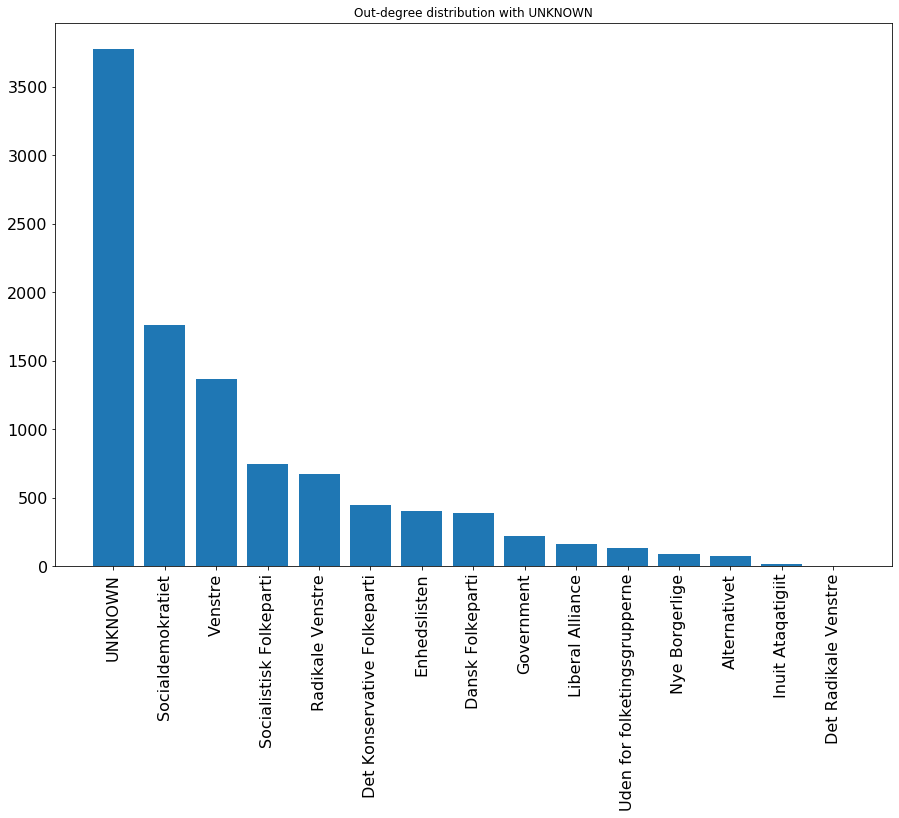

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_out_count.keys(), tweet_out_count.values())
plt.title("Out-degree distribution with UNKNOWN")
plt.show()

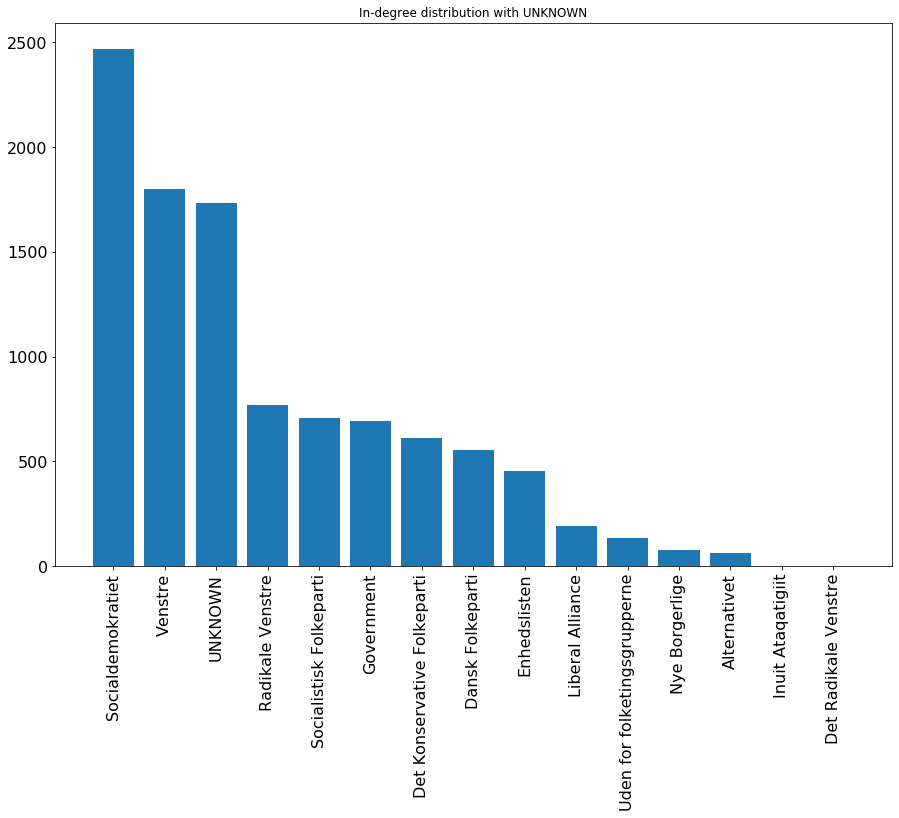

In [16]:
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_to_count.keys(), tweet_to_count.values())
plt.title("In-degree distribution with UNKNOWN")

plt.show()

## Without unknowns

In [17]:

tweet_to_count_clean = tweet_to_count.copy()
tweet_out_count_clean = tweet_out_count.copy()

tweet_to_count_clean.pop('UNKNOWN')
tweet_out_count_clean.pop('UNKNOWN')


3778

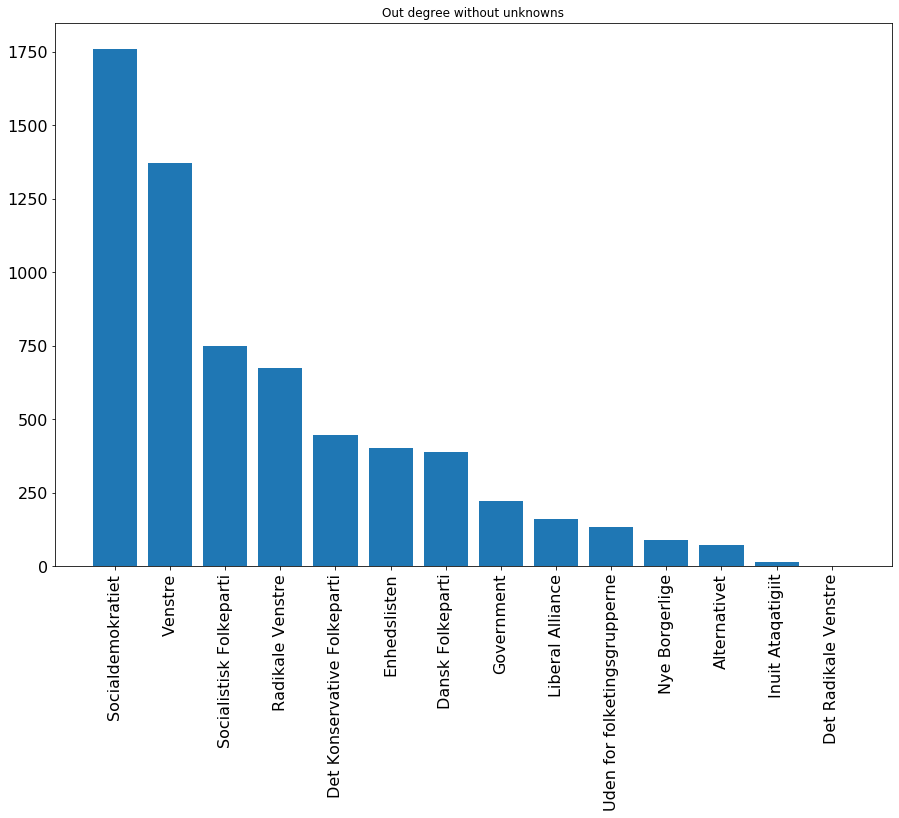

In [18]:
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_out_count_clean.keys(), tweet_out_count_clean.values())
plt.title("Out degree without unknowns")
plt.show()


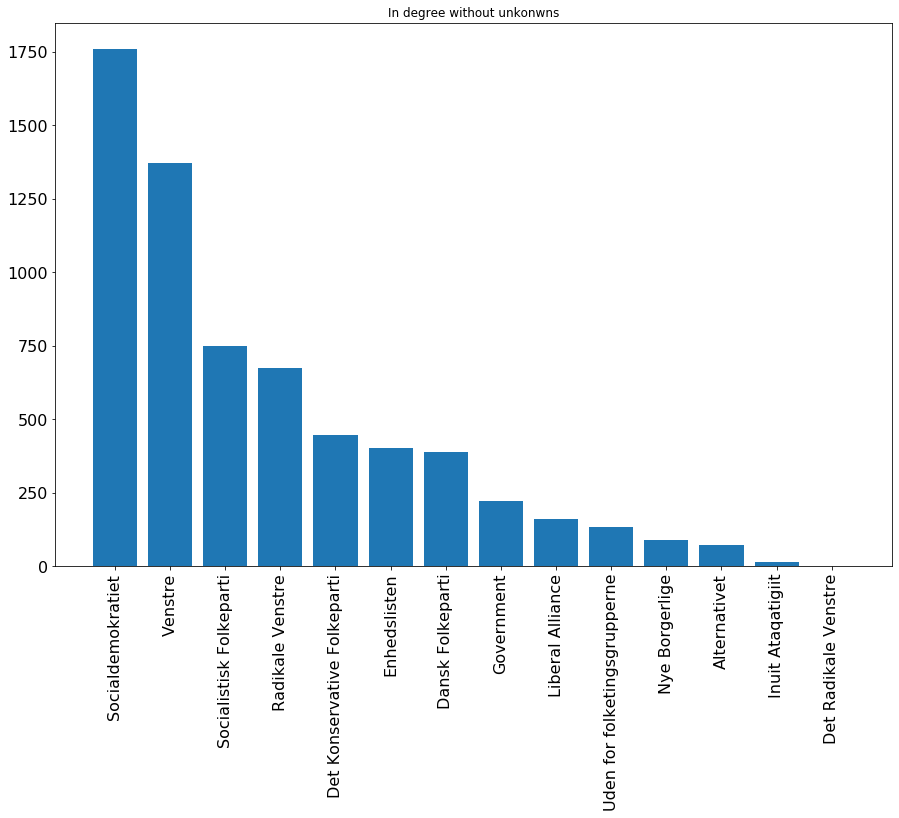

In [19]:

fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_out_count_clean.keys(), tweet_out_count_clean.values())
plt.title("In degree without unkonwns")
plt.show()

## Getting average as the amount of policians isn't at all evenly distributed

In [20]:
vals = nx.get_node_attributes(G, "party").values()
sum_party =dict.fromkeys(tweet_out_count.keys(),0)
for party_occ in vals:
    sum_party[party_occ] += 1
sum_party

avg_tweet_out = dict.fromkeys(tweet_out_count.keys())
avg_tweet_in= dict.fromkeys(tweet_to_count.keys())

for key in tweet_out_count:
    avg_tweet_out[key] = tweet_out_count[key] / sum_party[key]
    avg_tweet_in[key] = tweet_to_count[key] / sum_party[key]
    
ang_tweet_out = dict(sorted(avg_tweet_out.items(), key=lambda item: item[1],reverse=True))
avg_tweet_in = dict(sorted(avg_tweet_in.items(), key=lambda item: item[1],reverse=True))


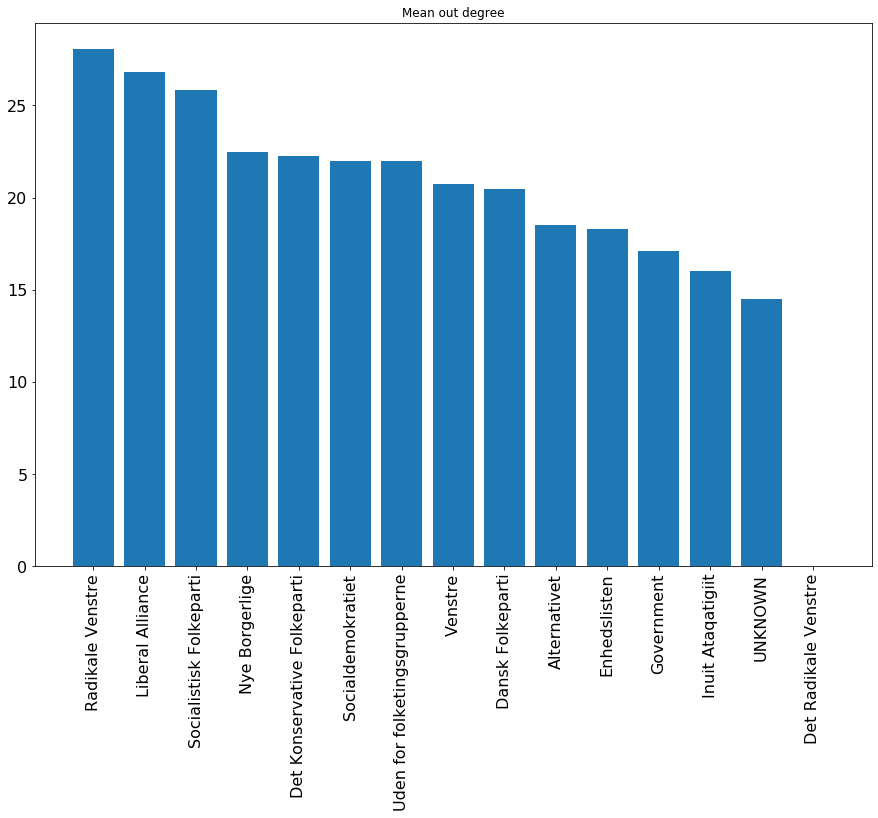

In [21]:
#ax = plt.subplot(111)

#x = pd.DataFrame([avg_tweet_in])
#chart =sns.barplot(x="day", y="total_bill",data=x)
#chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
#plt.show()
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(ang_tweet_out.keys(), ang_tweet_out.values())
plt.title("Mean out degree")
plt.show()

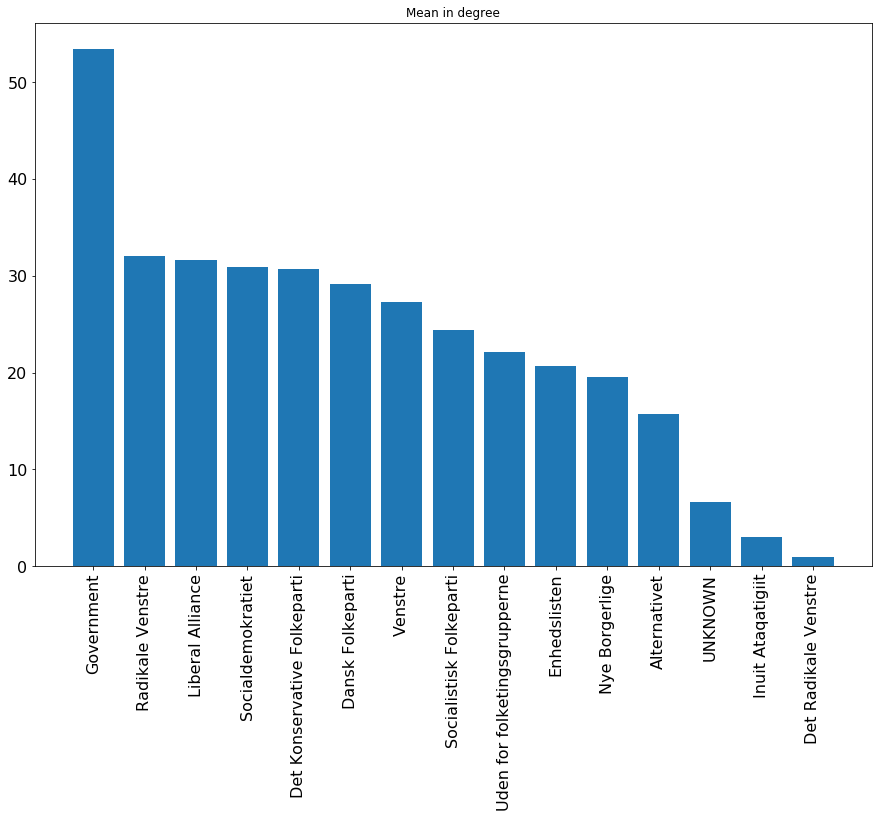

In [22]:
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(avg_tweet_in.keys(), avg_tweet_in.values())
plt.title("Mean in degree")
plt.show()

## Graph visualization

In [23]:
Gcc = sorted(nx.weakly_connected_components(G), key=len, reverse=True)

giant = G.subgraph(Gcc[0])
giant = giant.to_undirected()



for node in list(giant.nodes()):
    if (giant.degree(node) <= 2):
        giant.remove_node(node)

parties = list(nx.get_node_attributes(giant,'party').values())
color_map = []
d = dict(giant.degree) #degrees for every node

#Making color list
for i in range(len(parties)): #for all nodes
    if parties[i] == 'Socialdemokratiet':
        color_map.append('red')
    elif parties[i] == 'Venstre':
        color_map.append('blue')
        
    elif parties[i]=='Dansk Folkeparti':
        color_map.append('pink')
        
    elif parties[i]=='Socialistisk Folkeparti':
        color_map.append('brown')
        
    elif parties[i] == 'Radikale Venstre':
        color_map.append('#1f78b4')
        
    elif parties[i] == 'Enhedslisten':
        color_map.append('#D0004D')
        
    elif parties[i] == 'Det Konservative Folkeparti':
        color_map.append('#00583C')
        
    elif parties[i] == 'Nye Borgerlige':
        color_map.append('#235d66')
    elif parties[i] == 'Liberal Alliance':
        color_map.append('orange')
    elif parties[i] == 'Alternativet':
        color_map.append('yellow')
    elif parties[i] == 'Government':
        color_map.append('black')
    else:
        color_map.append('white')

100%|██████████| 2000/2000 [00:20<00:00, 96.78it/s]


BarnesHut Approximation  took  1.99  seconds
Repulsion forces  took  17.77  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.22  seconds
AdjustSpeedAndApplyForces step  took  0.34  seconds


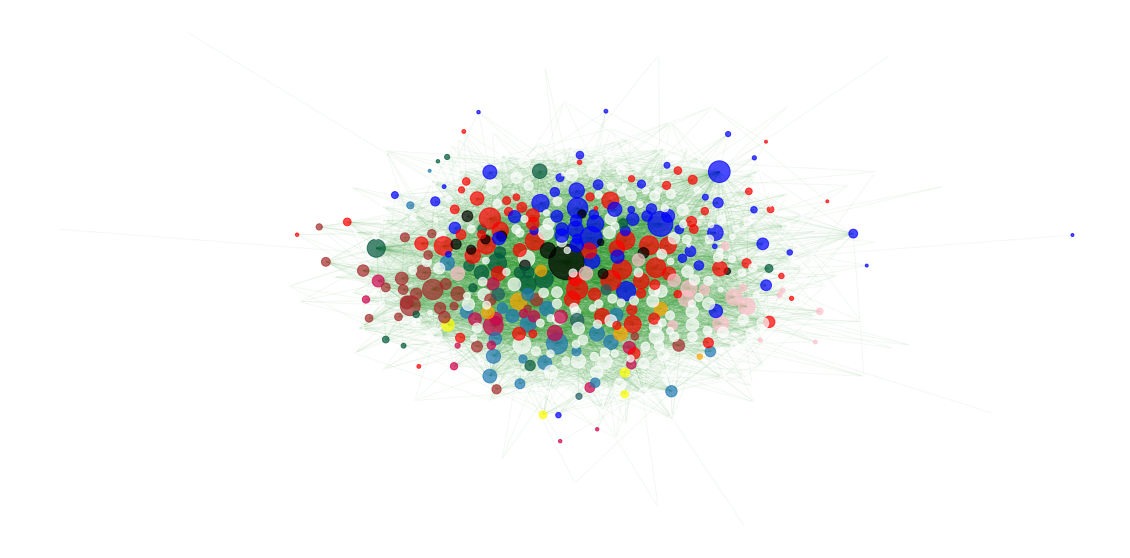

In [24]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, node_color=color_map, alpha=0.7,node_size=[v * 3 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

## Observations
The graph is quite compact, with many large blue and red nodes which makes sense, as these are the biggest parties in denmark; namely "Venstre" and "Socialdemokratiet". Furthermore, there are large black nodes that are central in the network - this also makes sense as we've marked government entities as black. However there are still some problems with the visualization that we want to solve.


# Segregating into red block vs blue block

The problem with the network visualization is that we have too many different parties and getting a nice visualization becomes difficult. Bloc politics refers to the act of parties uniting in order to gain a majority vote over the parliament. In danish politics, according to https://da.wikipedia.org/wiki/Blokpolitik we have 3 blocs, red blue and green. We will segregate our parties into this by adding a graph attribute "bloc" .

In [25]:
red_bloc = ['Socialdemokratiet', 'Enhedslisten', 'Socialistisk Folkeparti', 'Radikale Venstre']
blue_bloc = ['Venstre', 'Dansk Folkeparti', 'Det Konservative Folkeparti', 'Liberal Alliance', 'Nye Borgerlige', 'Fremad']
green_bloc = ['Alternativet']
    
    
for key, val in dict_of_attributes.items():
    print(key)
    if val['party'] in red_bloc:
        val['block'] = 'red'
    elif val['party'] in blue_bloc:
        val['block'] = 'blue'
    elif val['party'] in green_bloc:
        val['block'] = 'green'
    elif val['party'] == 'Government':
        val['block'] = 'black'
    else: 
        val['block'] = 'white' # white node means unknown
        
nx.set_node_attributes(G, dict_of_attributes)

Gcc = sorted(nx.weakly_connected_components(G), key=len, reverse=True)

giant = G.subgraph(Gcc[0])
giant = giant.to_undirected()
d = dict(giant.degree) #degrees for every node

for node in list(giant.nodes()):
    if (giant.degree(node) <= 2):
        giant.remove_node(node)

block_color_map = list(nx.get_node_attributes(giant, 'block').values())
print(block_color_map)

vestager
SchaldemoseMEP
karmel80
oestergaard
sofiecn
simonkollerup
jesper_bedreby
RohlChristopher
larsloekke
Statsmin
_MaiMercado
JakobEllemann
SorenPape
RasmusJarlov
BjBrandenborg
Kristianthdahl
Jesper_Pet
rasmusnordqvist
FrankJensenKBH
LouiseElholm
JanEJoergensen
RStoklund
regeringDK
LotteRod
aahlers
PiaOlsen
signe_munk
PSkipperEL
MaiVilladsen
rubenkidde
DanJoergensen
NWammen
FrkCallesen
SamiraNawa
a_steenberg
stinuslindgreen
karinFbach
KatrineRobsoe
martinlidegaard
metteabildgaard
olebirkolesen
Hans_Kr_Skibby
LeaWermelin
mortenhelveg
Joymogensen
SandKjaer
orlaosterby
Sten_Knuth
BirgitteBergman
brittbager
zeniastampe
JeppeBruus
mattiastesfaye
RosenkrantzT
KHegaard
krarup_lars
Pia_Kjaersgaard
pederhvelplund
MogensJensenS
RosaLundEl
EvaFlyvholm
JakobSoelvhoej
AndersKronborg
nvillumsen
StemLAURITZEN
mfMorten
RuneLundEL
Heunicke
karinaehl
Danielpanduro
mariagudme
PHummelgaard
VictoriaRV
uffeelbaek
IdaAuken
Paulin_Anne
larsgaardhoj
skaarup_df
MargreteAuken
ammitzbollbille
MrMesserschmidt


100%|██████████| 2000/2000 [00:20<00:00, 97.80it/s] 


BarnesHut Approximation  took  1.98  seconds
Repulsion forces  took  17.60  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.20  seconds
AdjustSpeedAndApplyForces step  took  0.37  seconds


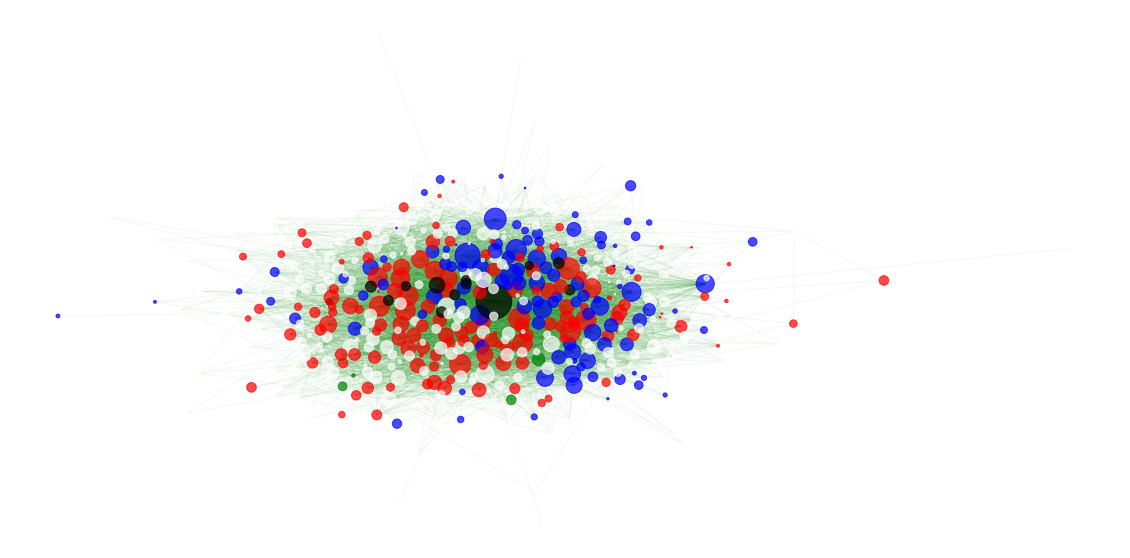

In [26]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, node_color=block_color_map, alpha=0.7,node_size=[v * 3 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

Now we can observe some seperation between the red and blue blocs, with government entities in the middle (black nodes)

Let's try to eliminate the white ('UNKNOWNS')

In [27]:
for node in list(giant.nodes(data=True)):
    if (node[1]['block'] == 'white'):
        giant.remove_node(node[0])
block_color_map = list(nx.get_node_attributes(giant, 'block').values())
d = dict(giant.degree) #degrees for every node

print(block_color_map)

['red', 'red', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'blue', 'red', 'red', 'blue', 'blue', 'red', 'black', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'blue', 'blue', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'red', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'black', 'black', 'blue', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'red', 'blue', 'red', 'red', 'blue', 'blue', 'green', 'red', 'red', 'red', 'red', 'red', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'blue', 'blue', 'blue', 'red', 'red', 'blue', 'red', 'blue', 'red

100%|██████████| 2000/2000 [00:06<00:00, 288.80it/s]


BarnesHut Approximation  took  0.79  seconds
Repulsion forces  took  5.71  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.10  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds


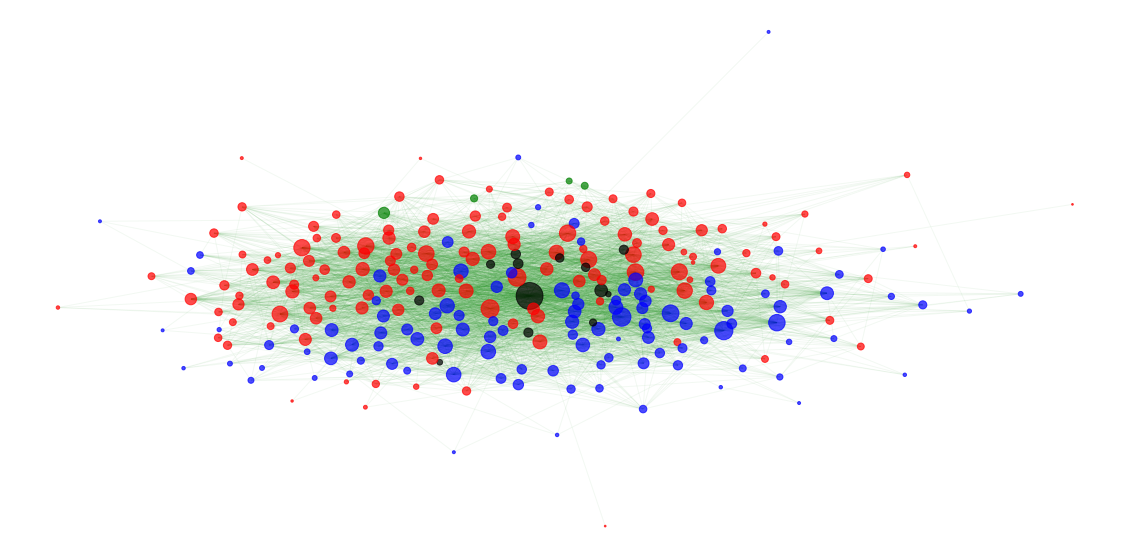

In [28]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, node_color=block_color_map, alpha=0.7,node_size=[v * 3 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

The network looks a bit neater, but we can observe that the large central government profiles have decreased in degree, signalling that a lot of the unknowns have tweeted to that profile. Interestingly, the few green block nodes are leaning to the right. Now we will look at sentiment of tweets, that link 2 profiles.

### Sentiment

We want to analyze the sentiment score that the tweets have associated to them, moreover we want to get an idea of how cross party tweets are scored. This could for example, show that a certain party may agree more, on average than an other party, would this be as expected regarding the block politics we've described earlier? This is what we look to find out

In [29]:
#!pip install afinn
#!pip install langdetect

from langdetect import detect
from afinn import Afinn
afinn = Afinn()
afinn_da = Afinn(language='da')

In [30]:
with open('tweet_dict_listversion_wrealnames_v2.data', 'rb') as filehandle:
    tweet_dict = pickle.load(filehandle) 

In [31]:
# helper function
def get_party(node):
    # returns party of a node
    x = data.loc[data['Twittername'] == node]    
    for w in x['Party']: # returns one item couldn't do x['Party'][0] for some reason
        return w



In [32]:
total_sentiment = dict.fromkeys(unique_parties)
for key, value in total_sentiment.items():
    total_sentiment[key] = { i : {'scores':[], 'mean': 0} for i in unique_parties }


In [33]:
# for each tweet calculate a score 
# get from party and to party
# update total
count = 0

for key,value in tqdm(tweet_dict.items()):
    #print(key)
    from_party = get_party(key)
    for mention, texts in value.items():
        to_party = get_party(mention)
        for tweet in texts:
            # remove @s
            tweet = re.sub(r'@\w+\b', '', tweet)
            tweet = tweet.strip()
            try:
                lang = detect(tweet)
            except Exception as e:
                print(e)
                print("tweet = " + tweet)
                continue # skip
            if lang == 'da':
                score = afinn_da.score(tweet)
            elif lang == 'en':
                score = afinn.score(tweet)
            else:
                score = afinn_da.score(tweet)
                print(tweet)
                print("Language    " + lang)
                print("debug: " + str(afinn_da.score(tweet)))
                continue

            try:
                total_sentiment[from_party][to_party]['scores'].append(score)
            except Exception as e:
                print("Error" + str(e))
                #print("Backlog: ")
                #print("tweet from "  + key + " to " + mention)


Tillykke!!
Language    no
debug: 2.0
I er velkomne 😀- god sommer. https://t.co/TQCVvAlOpm
Language    no
debug: 3.0
Men du fik din historie alligevel. Skam dig! https://t.co/cPD6ZmMAg9
Language    af
debug: 0.0
(du svarede så prompte på mit første opslag, så kan du ikke også svare på dette?)
Language    no
debug: 0.0
Og det fortalte i ham så?
Language    no
debug: 0.0
I know.
Language    pl
debug: 0.0
Nok for meget forlangt. 😄
Language    no
debug: -2.0
RT :  Flot grøn alliance , , , ,  , 

Vil …
Language    it
debug: 3.0
RT : Selv tak  Tak fordi du har gjort  til et skoleparti igen bl.a. ved at prioritere flere lærere på fina…
Language    no
debug: 4.0
RT : Christian Fuhlendorff og  går to ture og snakker klima, kunstig intelligens, troen på fremtiden, tillid til…
Language    no
debug: 2.0
Tillykke begge to!
Language    no
debug: 2.0
Stort tillykke
Language    no
debug: 2.0
Du laver forhåbentlig sjov. Det var virkelig en fordomsfuld, usympatisk og verdensfjern kommentar. Du har da vis

No features in text.
tweet = 💪💚
RT : Man har kun brug for en hockey-stav, hvis man er på glatis. 
Støtter  egentlig reelt 70-procents målet? Så vis os…
Language    no
debug: 2.0
Det har du misforstået så. Hun svarede på spørgsmål fra BT.
Language    no
debug: -2.0
Vi har ikke trukket den frem. Vi har svaret på spørgsmål pressen stiller. Og jeg tror ikke det kan undgås at en sag der for mig er klokkeklar #metoo tages frem.
Language    no
debug: -1.0
Det har du misforstået så. Hun svarede på spørgsmål fra BT.
Language    no
debug: -2.0
Kæmpe respekt. Tak 🙌❤️
Language    no
debug: 3.0
Tak 💚
Language    id
debug: 2.0
statsministeriet bliver styrket #dkpol https://t.co/8uarlo0vm3
Language    no
debug: 2.0
ErrorNone
ErrorNone
ErrorNone
ErrorNone
RT : 13 projekter, som vil styrke den grønne omstilling i landbrugs- og fødevaresektoren, får tilsammen knap 100 mio. kroner fra …
Language    no
debug: 2.0
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
RT : Bred klimaaftale m

Stort tillykke, Sophie💪🏻😊
Language    no
debug: 2.0
RT : Selvfølgelig skal rammerne for genåbning være trygge. Det mener vi også i  - vi skal passe på risikogrupper bland…
Language    no
debug: 1.0
Stort tillykke til  med sin første tjans i formandsstolen 😃😎🇩🇰 #dkpol https://t.co/RCZVUdTYDp
Language    no
debug: 2.0
RT : Klar med    på #Verdenspressen på  - vi snakker USA, Hong Kong, Kashmir mm.…
Language    no
debug: 1.0
Kunne man tilføje download app til disse skilte? #Covid19dk https://t.co/kOOQ26dT3N
Language    no
debug: 0.0
5te gang er lykkens gang... nu er min app store også opdateret
Language    no
debug: 3.0
Har ventet siden maj tror jeg 😂 men ja
Language    no
debug: 1.0
Fysisk eller psykisk?
Language    no
debug: 0.0
Ahhh
Language    vi
debug: 0.0
Hørt!
Language    no
debug: 0.0
Hørt!
Language    no
debug: 0.0
Modtaget! Vi presser på.
Language    no
debug: 0.0
RT : Interessant indspark i debatten om #DR fra : https://t.co/uR7OVKSl3o #dkpol
Language    no
debug: 2.0
Enig!
Lan

Vi styrker kontrollen med dyretransporter. For dyrenes skyld. Tak for konstruktive snakke og for en bred aftale til , , , , , , , , ,  #dkpol https://t.co/GXAstOquzf
Language    no
debug: 3.0
Vi styrker kontrollen med dyretransporter. For dyrenes skyld. Tak for konstruktive snakke og for en bred aftale til , , , , , , , , ,  #dkpol https://t.co/GXAstOquzf
Language    no
debug: 3.0
RT : Stort tillykke til  med 40 års jubilæum i  Fortjente blomster og klapsalver fra  https:…
Language    no
debug: 2.0
RT : Stort tillykke til  med 40 års jubilæum i  Fortjente blomster og klapsalver fra  https:…
Language    no
debug: 2.0
RT : Ingen er i tvivl om forskellen på kompliment og sexistisk kommentar. Det første gør glad. Det andet gør knastør i trussen. At…
Language    no
debug: 2.0
Åhh Mai. Tror muligvis jeg elsker dig. 😂❤️😂😍
Language    no
debug: 2.0
Så fik jeg byttet rundt og  fik mit like i stedet 😂
Language    no
debug: 4.0
RT : Positivt, at S åbner for skattelettelser i  i morgen. Det er pot

Jeg kunne svare: Sikke en latterlig kommentar. Men fortæl hellere hvad du mener og hvorfor?
Language    no
debug: -2.0
Damn. Jeg er nr 57 med mine 8 arter 👀. Men alle mine fotos er fra i dag. Ikke gamle anemoner fra i foråret 💪😇💚
Language    no
debug: 0.0
ErrorNone
ErrorNone
ErrorNone
ErrorNone
Tak😀
Language    sw
debug: 2.0
Jeg kunne svare: Sikke en latterlig kommentar. Men fortæl hellere hvad du mener og hvorfor?
Language    no
debug: -2.0
Damn. Jeg er nr 57 med mine 8 arter 👀. Men alle mine fotos er fra i dag. Ikke gamle anemoner fra i foråret 💪😇💚
Language    no
debug: 0.0
Damn, jeg nakkede to mejeredderkopper i går. Skulle ha' ventet og fotograferet dem først :-) Jeg må på jagt efter noget andet. Super initiativ 💪🦋🕷️🐌🐞🐛
Language    no
debug: 5.0
Jeg kunne svare: Sikke en latterlig kommentar. Men fortæl hellere hvad du mener og hvorfor?
Language    no
debug: -2.0
Jeg kunne svare: Sikke en latterlig kommentar. Men fortæl hellere hvad du mener og hvorfor?
Language    no
debug: -2.0
De

First like!
Language    no
debug: 0.0
Ja præcis 😋
Language    pt
debug: 3.0
tak for opklaring. Det kunne godt forstås anerledes
Language    no
debug: 5.0
First like!
Language    no
debug: 0.0
First like!
Language    no
debug: 0.0
No features in text.
tweet = 💛💙💛💙
*NC3
Language    vi
debug: 0.0
First like!
Language    no
debug: 0.0
First like!
Language    no
debug: 0.0
first like!
Language    no
debug: 0.0
*NC3
Language    vi
debug: 0.0
*NC3
Language    vi
debug: 0.0
i deres FRITID!
Language    ca
debug: 0.0
Mange tak Uffe🙏🏼
Language    id
debug: 2.0
RT : #dkpol  https://t.co/uMePeKj0Cf
Language    sk
debug: 0.0
Mange tak Uffe🙏🏼
Language    id
debug: 2.0
Mange tak Uffe🙏🏼
Language    id
debug: 2.0
No features in text.
tweet = https://t.co/UYC7WqHulv
Fra de to partiers mund
Language    es
debug: 0.0
Skattelylisten skal strammes op - og de europæiske skattely skal ikke kunne undtages  #eudk #dkpol https://t.co/dcm9jgdYq6
Language    no
debug: 0.0
Enig Michael!
Language    de
debug: 1.0
Don

RT : Hvad skal med i DK's kommende handlingsplan for #Verdensmålene? Fint anslag fra   og .  
https…
Language    no
debug: 2.0
RT : Denne rapport er en blinkende alarm 😢

Sent anbragte kæmper med selvskade, misbrug, kriminalitet og dårlig trivsel. Vi skal…
Language    no
debug: -13.0
RT : Snart 40 år i centraladministrationens og statens tro tjeneste - og de seneste 25 år i rollen som departementschef i …
Language    no
debug: 1.0
Dansk Kyst- og Naturturisme overrækker mandag ny handlingsplan for outdoorturismen, og erhvervsminister  kommer på banen for at kvittere. Mountainbike-banen faktisk. Læs mere her: https://t.co/fdMD1u9edY #dkjournos #dkturisme #cykelland #dkoutdoor #nordjylland https://t.co/80XTNnW9Nz
Language    no
debug: 0.0
Helt enig 👍
Language    nl
debug: 1.0
Helt enig 👍
Language    nl
debug: 1.0
Helt enig 👍
Language    nl
debug: 1.0
Helt enig 👍
Language    nl
debug: 1.0
Helt enig 👍
Language    nl
debug: 1.0
Helt enig 👍
Language    nl
debug: 1.0
Tillykke 👏🇩🇰👏
Language    

RT :    Vi koordinerer jo 😂😂💚💚 https://t.co/ECMEYe74ha
Language    no
debug: 0.0
RT :    Vi koordinerer jo 😂😂💚💚 https://t.co/ECMEYe74ha
Language    no
debug: 0.0
Fynsk rygeost er fantastisk
Language    no
debug: 4.0
Tillykke til  ,  og  som nye ministre. Jakob har gjort det fantastisk som politisk ordfører, Eva er driftssikker og Tommy bliver en spændende fornyelse 👍🏻 #dkpol
Language    no
debug: 9.0
Tillykke til  ,  og  som nye ministre. Jakob har gjort det fantastisk som politisk ordfører, Eva er driftssikker og Tommy bliver en spændende fornyelse 👍🏻 #dkpol
Language    no
debug: 9.0
RT :    Vi koordinerer jo 😂😂💚💚 https://t.co/ECMEYe74ha
Language    no
debug: 0.0
RT : Venstre goes green 👍🌍 https://t.co/k69GILezVz  #dkpol #energi https://t.co/s9pOTWUQ4J
Language    af
debug: 0.0
så er jeg klar til at svare på spørgsmål til regeringen på p1👍#dkpol #dkmedier https://t.co/vgvp21mi9z
Language    no
debug: 1.0
RT : God finanslovsdebat til hele #dkpol i dag 👍
 
Og tak til  for et godt svar p

Hov hov. Kast ikke med sten når du bor i et glashus  
Det er et relevant spg. fra   og I  spreder jo selv konstant #fakenews. Se bare Aalborg Portland. Pinligt. Fej for egen dør. https://t.co/Ciqy9TBYm1
Language    no
debug: -3.0
RT : Der venter en stor regning for nedlukningen. Heldigvis er 🇩🇰 godt rustet. Det har , , …
Language    no
debug: 5.0
RT : Der venter en stor regning for nedlukningen. Heldigvis er 🇩🇰 godt rustet. Det har , , …
Language    no
debug: 5.0
RT : Der venter en stor regning for nedlukningen. Heldigvis er 🇩🇰 godt rustet. Det har , , …
Language    no
debug: 5.0
RT : DANMARK ER VENSTREBLÅT ❤️💙🇪🇺🇩🇰 #EP2019 #FV19 #dkpol https://t.co/iU2ZdDANTS
Language    de
debug: 0.0
Tillykke med valget 👍🏼
Language    no
debug: 2.0
Tillykke med i morgen 🇩🇰
Language    no
debug: 2.0
Det har du fuldkommen ret i  https://t.co/2Dt0FxSekZ
Language    no
debug: 0.0
Tak. Det er simpelthen så grotesk!
Language    no
debug: -1.0
Tillykke! Sejt 👊🏼
Language    no
debug: 2.0
Respekt!
Language    

RT : Børnenes finanslov ❤️ https://t.co/yVLGIoP5Ad
Language    no
debug: 0.0
RT : Hvad f..... har hun gang i!! Ikke stemme på søndag ! I Danmark hvor vi har folkestyre og demokrati. Fordi NB ikke selv…
Language    no
debug: 0.0
rt : hver anden nye coronasmittede i aarhus er somalier – helt grotesk, mener pia kjærsgaard - https://t.co/5c6emynbzn http…
Language    no
debug: -3.0
RT : Den Korte Avis | DF-ikonet Søren Krarup er atter aktiv – støtter Martin Henriksen i hans valgkamp: https://t.co/ZlyHKhr4IB
Language    no
debug: 3.0
hvem har talt mest om islam fra folketingets talerstol? marie krarup! nr to er christian langballe! så sig ikke, at vi ikke har sat islam på dagsordenen. 
https://t.co/t1u3cyzas1
Language    no
debug: 0.0
Ja. Ret interessant. :-) https://t.co/6OQnVFqYfr
Language    de
debug: 3.0
Hvornår vil vi kunne teste 5.000 om dagen? Kan  svare? #dkpol https://t.co/ns5Wy96whJ
Language    no
debug: 0.0
jeg synes godt nok  skylder en forklaring her: hvorfor skulle der gå så la

No features in text.
tweet = 💛💙
Du kan simpelthen ikke se problemet i, at du er hellig som paven, mens du selv bryder reglerne fordi du skal i Det Kongelige med dine venner? Jeg har lært at man skal feje foran sin egen dør først
Language    no
debug: 0.0
Hvilket mønster vil du sige at du viser her, Peter? Man skal ikke kaste med sten når man selv bor i glashus: https://t.co/34bMoSPsSm
Language    no
debug: 1.0
No features in text.
tweet = 🤦‍♂️🤦‍♂️
No features in text.
tweet = 💛💙
No features in text.
tweet = 💛💙
No features in text.
tweet = 💛💙
No features in text.
tweet = 💛💙
Vi må have samme slags spam-filter. Pokkers!
Language    no
debug: -6.0
RT : 💪💪💪💪 kilde: NB-Økonomo #dkpol https://t.co/mTBqf6Cvfs
Language    sl
debug: 0.0
RT : Hovsa Mette! Overbetaling??? Prøv lige at tjekke fakta. #dkpol #fv19 https://t.co/5sCITYL5Px
Language    no
debug: 0.0
Det måtte jo komme på et tidspunkt 😂😂
Language    no
debug: 0.0
Sikke noget vrøvl!
Language    no
debug: 0.0
Sikke noget vrøvl!
Language   

jeg har spurgt regeringen til, hvad denne type diplomatiske forsikringer giver anledning til i fremtiden. jeg venter endnu på svaret
Language    no
debug: -1.0
Jeg har stillet spørgsmål til ministeren om netop dette!
Language    no
debug: 0.0
Jeg har stillet spørgsmål til ministeren om netop dette!
Language    no
debug: 0.0
Jeg har stillet spørgsmål til ministeren om netop dette!
Language    no
debug: 0.0
:     Virker ellers som om at de smider mange Q-kommentarer i V. http://t.co/xLh35uUcw9
Language    no
debug: 0.0
No features in text.
tweet = ...https://t.co/LgAgTodLPH
Og han bekræfter igen og igen, at han ville have tøvet, gjort som Sverige mv.
Language    no
debug: 0.0
No features in text.
tweet = ...https://t.co/LgAgTodLPH
Lyt lyt lyt :)
Language    fi
debug: 0.0
Selv tak fra en far til to piger..
Language    no
debug: 2.0
Helt fantastisk dag 🙏👏💪🤝❤️
Language    no
debug: 4.0
Selv tak fra en far til to piger..
Language    no
debug: 2.0
Helt fantastisk dag 🙏👏💪🤝❤️
Language    no
deb

Ja!
Language    sw
debug: 1.0
Du kan jo spørge den ansvarlige minister.  Han svarede ret klart i Politiken i søndags. Og i og med han har været ansvarlig for de førte forhandlinger, ved han nok, hvad han taler om.
Language    no
debug: 3.0
ErrorNone
rt : s-regeringen og mette f gav topskattelettelser. vil de rulle dem tilbage? nej. det er meget sjovere at beskylde v for top…
Language    no
debug: 3.0
No features in text.
tweet = 💚🙏🏼
RT : Derfor forventer jeg også stor opbakning til beslutningsforslaget om en Biodiversitetslov den 10.november.
Language    no
debug: 2.0
RT : Yes! 

#Elections2020 #dkpol
Language    fr
debug: 2.0
strakspåbud og forbud er oppe på 80 på storstrømsbroen.
det er en skandale. det bør stoppes.
jeg har beskæftigelsesminister peter hummelgaard i samråd mandag kl. 14. #dkpol https://t.co/w2qy4svwai
Language    no
debug: -5.0
No features in text.
tweet = 💪😂
Tusind tak Jesper!🙏
Language    id
debug: 2.0
Ej Ellen, du er sgu bedre end det. Ingen skjuler noget og Mølba

Tak for din hilsen Birgit.
Jeg har altid kunnet lide dig og din dømmekraft. Dømmekraften hvad angår ishockey, - det er en ommer 😊😉
Language    no
debug: 4.0
Selv tak min ven. 
Også fordi du overkommer det store hverv som KL-formand. Til gavn for mange. Bh Lars
Language    no
debug: 4.0
Mange tak Steen. Og hold kommune-fanen højt.
Language    no
debug: 2.0
Genkendt😎. Brdr. Price, Herning 👍 https://t.co/WdYj3eBWgB
Language    de
debug: 0.0
Jamen så mangler “vi” jo bare de tre mia... 😉🥴
Language    no
debug: -2.0
No features in text.
tweet = 😉👍 https://t.co/PWVzYlqbJf
No features in text.
tweet = 😉👍 https://t.co/PWVzYlqbJf
Begge dele
Language    no
debug: 0.0
Ha ha ha - du er i Herning. Men tryg  (ikke tryk...😂😂)
Language    no
debug: 8.0
Jamen så mangler “vi” jo bare de tre mia... 😉🥴
Language    no
debug: -2.0
RT : Kun ét år til vi skal til kommunal- og regionalvalg,  på #rvlm20. Demokratiet er noget vi deler med hinanden. Og…
Language    no
debug: 0.0
Måske skulle mit deep learning proj

ErrorNone
Stort tillykke til  og Inger Støjberg. Det skal nok blive godt. 👍 #dkpol #velm19 https://t.co/uW3DHvx8KY
Language    no
debug: 5.0
Tak Karen!
Language    id
debug: 2.0
vi ønsker en plan fra venstre hr. lars løkke rasmussen.#dkpol
Language    no
debug: 2.0
jacob jensen gav jo ikke svar på om dagpengene skulle skæres, kom dog med et svar, ja eller nej #dkpol
Language    no
debug: 0.0
nye toner fra venstre. torsten schack mener det er ok, at df kan love alt hvad de vil, 364 dage om året, bare ikke i finansloven.#dkpol
Language    no
debug: 0.0
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
mangler stadig at svare, Ole 🙂
Language    sv
debug: -2.0
ErrorNone
Jeg støtter ikke forslaget om at forbyde navnet “grønne burgere”. Jeg elsker faktisk både grønne burgere og grønne pølser 😋
Language    no
debug: 2.0
ErrorNone
ErrorNone
ErrorNone
ErrorNone
Vi er på linje Troels !
Language    no
debug: 0.0
Jeg stemmer ud fra min overbevisning. Jeg mener ikke EU skal bruge den grønne just tr

Jeg er forresten nu ledig på Fri Transfer 😉
Language    no
debug: 1.0
Jeg er forresten nu ledig på Fri Transfer 😉
Language    no
debug: 1.0
Heller ikke
Language    no
debug: 0.0
Heller ikke.
Language    no
debug: 0.0
Det var det ikke nej
Language    no
debug: -1.0
Hun er radikal. Så nej - det var ikke en radikal
Language    no
debug: -1.0
Heller ikke
Language    no
debug: 0.0
Heller ikke.
Language    no
debug: 0.0
Det var det ikke nej
Language    no
debug: -1.0
Hun er radikal. Så nej - det var ikke en radikal
Language    no
debug: -1.0
Heller ikke
Language    no
debug: 0.0
Heller ikke.
Language    no
debug: 0.0
Heller ikke
Language    no
debug: 0.0
No features in text.
tweet = https://t.co/F7855bSHcP
Tak Kristian🥰
Language    id
debug: 2.0
Min personlige historie
Language    af
debug: 0.0
Sejt!
Language    sq
debug: 0.0
RT : Kontakttallet for smittede er faldet fra 1,5 til 1,3. Smitten stiger altså fortsat, men i lavere tempo. Vi skal under 1, før…
Language    no
debug: -6.0
RT : Konta

Det er jo jer man kunne sige, at politik gør en forskel
Language    no
debug: 0.0
Hørt
Language    no
debug: 0.0
Hørt
Language    no
debug: 0.0
Se her hvad   har gjort https://t.co/otPuG8nxIG
Language    no
debug: 0.0
No features in text.
tweet = 👏🏼👏🏼👏🏼👏🏼
No features in text.
tweet = ❤️❤️
No features in text.
tweet = 🥰
ErrorNone
Se her :-) https://t.co/RCxK9t5o6t
Language    de
debug: 0.0
Brobygning og studiedage er simpelthen bare noget I maner man kan og skal spare væk? Det mener jeg i hvert fald ikke!
Language    no
debug: 0.0
Det er min klare forventning.
Language    no
debug: 0.0
Do it!😂
Language    de
debug: 0.0
Do it!😂
Language    de
debug: 0.0
RT : Corona-epidemi skal ikke føre til finanskrise. Landets førende økonomer opfordrer til en 300 mia. stor statslig krisefond.…
Language    no
debug: 0.0
Hvordan ønsker I så at finansiere det? Det kunne vi i hvert fald ikke få svar på i salen i fredags.
Language    no
debug: 2.0
Selv tak - jeg håber du ved, at vi vil gøre, alt hvad vi ka

VI vil ha’ flere!!
Language    no
debug: 2.0
VI vil ha’ flere!!
Language    no
debug: 2.0
RT : Slingrekurs i  på grønne biler. Først mente V 1 mio grønne biler. Men da prisen stod klar, slog  bak "…
Language    no
debug: 0.0
Måske.
Language    no
debug: 0.0
RT : Slingrekurs i  på grønne biler. Først mente V 1 mio grønne biler. Men da prisen stod klar, slog  bak "…
Language    no
debug: 0.0
Nok meget godt at man ikke driver samfundsøkonomien med din vennetjenestelogik.
Language    no
debug: 3.0
ErrorNone
Var ikke obs på nye regler. Tager det i mig igen.
Language    no
debug: 0.0
Nej.
Language    sk
debug: -1.0
Tak  💪❤️ #dkpol https://t.co/FMo0tVsKer
Language    id
debug: 2.0
RT : #dkpol https://t.co/RB4OsCwlwF
Language    sk
debug: 0.0
Tænkte nok 👍🙏
Language    no
debug: 0.0
Sejt gået  💚❤️💚
Language    sq
debug: 0.0
Sejt gået  💚❤️💚
Language    no
debug: 0.0
Og du var fantastisk ❤️💚❤️
Language    sv
debug: 4.0
RT : Klima nu! Det kan ikke vente #dkpol #dkgreen
Language    af
debug: 0.0
RT

Tak😊🌹
Language    sw
debug: 2.0
Savner jer, mine kollegaer😞
Language    no
debug: 0.0
God bedring🌹
Language    cy
debug: 3.0
Ha ha ha! Så er det straks meget mere passende😅
Language    no
debug: 6.0
Tror faktisk også Irma har😍
Language    no
debug: 0.0
Tak😍💪🏻🌹
Language    sw
debug: 2.0
Stort tillykke😊🌹
Language    no
debug: 2.0
Mange tak☺️🙏🏻
Language    id
debug: 2.0
Altså du er blevet min yndlings-konser. Så fortjent vil jeg sige😊
Language    no
debug: 1.0
“Knastør i trussen”. Sådan skal det siges! Tak  https://t.co/FoCGWPVlaF
Language    no
debug: 2.0
Tillykke til os🥰🇩🇰🌹
Language    no
debug: 2.0
Wauw😍🚝
Language    sw
debug: 0.0
Enig
Language    de
debug: 1.0
Enig
Language    de
debug: 1.0
Enig
Language    de
debug: 1.0
Det er sgu god humor 😂😂😂
Language    cy
debug: 5.0
Mona Vinter 😂
Language    it
debug: 0.0
Helt enig
Language    nl
debug: 1.0
Enig, det må vi regne med at ministeren har gjort.
Language    no
debug: 1.0
Enig, det må vi regne med at ministeren har gjort.
Language    n

RT : På  i dag for at diskutere kommunernes økonomi. Når pengekasserne vokser, skyldes det, at  og …
Language    no
debug: 1.0
RT : "Tulle-torpedo" direkte ind i siden på Løkkes treparts-projekt. Uhørt DF angreb på Løkke. Det sejler i blå blok #dkpol
Language    no
debug: -2.0
RT : På  i dag for at diskutere kommunernes økonomi. Når pengekasserne vokser, skyldes det, at  og …
Language    no
debug: 1.0
RT : Video:  og  om økonomiaftalen #dkpol #kompoldk https://t.co/fyDEdCQ4Cf
Language    no
debug: 0.0
RT : Video:  og  om økonomiaftalen #dkpol #kompoldk https://t.co/fyDEdCQ4Cf
Language    no
debug: 0.0
RT :      I måtte jo vinde engang... Godt spil fra begge hold. #enli…
Language    no
debug: 5.0
Den var legendarisk 😂 (stemte også blankt)
Language    no
debug: 0.0
Godt!
Language    de
debug: 3.0
No features in text.
tweet = ❤️
Seje, seje  ❤️
Language    sl
debug: 0.0
Seje, seje  ❤️
Language    sl
debug: 0.0
No features in text.
tweet = 💪💪💪
Flot    ❤️ https://t.co/VEhNK8m6jV
Language    

enig. vh erling bonnesen (v)
Language    no
debug: 1.0
RT : Stort og varmt velkommen til  nye partisekretær . Jeg er meget glad for, at du takkede ja!
Language    no
debug: 8.0
RT : Ja tak. https://t.co/tc74bn7vTG
Language    id
debug: 3.0
rt : fuld opbakning til jakob ellemann-jensen som ny formand for venstre. han bliver en god formand for venstre #dkpol …
Language    no
debug: 5.0
RT :        Meget klar Venstre lin…
Language    no
debug: 1.0
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
RT :        Meget klar Venstre lin…
Language    no
debug: 1.0
RT :        Meget klar Venstre lin…
Language    no
debug: 1.0
RT :        Meget klar Venstre lin…
Language    no
debug: 1.0
RT :        Meget klar Venstre lin…
Language    no
debug: 1.0
Enig. Vh Erling Bonnesen (V)
Language    de
debug: 1.0
Enig. Vh Erling Bonnesen (V)
Language    de
debug: 1.0
Enig. Vh Erling Bonnesen (V)
Language    de
debug: 1.0
RT : Kanon og velfortjent start for  dygtige nye formand 💪 #dkpol https://t.co/X2PipQcJk

ErrorNone
ErrorNone
ErrorNone
Det kunne være kønt...
Language    no
debug: 0.0
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
har med  i spidsen travlt med politiske drillerier. Politikere fra V kommer med meldinger i øst og vest.  har heldigvis en sikker hånd på rettet https://t.co/3SzI2ESkm0 #dkpol
Language    no
debug: 5.0
No features in text.
tweet = https://t.co/WtViCR5gUJ
13. Oktober stiller du spørgsmål i dagspressen om det er nødvendig at slå syge mink ihjel. I går ville  have timeout.  mener det går for langsomt med at slå mink ihjel. Det er vist godt  ikke har regeringsansvaret med den slingrekurs.
Language    no
debug: -1.0
No features in text.
tweet = https://t.co/DUCPYFixzh
Ser vi snart planen fra  og  ? https://t.co/WmzElSbK8x
Language    no
debug: 0.0
Vi venter fortsat på svar fra  og  ? https://t.co/FNA6DDp2so
Language    no
debug: -1.0
har med  i spidsen travlt med politiske drillerier. Politikere

Flot, flot åbningstale 👍👍
Language    sv
debug: 6.0
genvalg - tak 👍
Language    af
debug: 2.0
Flot tale Rasmus.
Language    et
debug: 3.0
RT : Leg med og vind, når vi kl. 14.15 inviterer til klassisk bingo med , , Erik Buhl og  p…
Language    no
debug: 1.0
RT : Leg med og vind, når vi inviterer til klassisk bingo med , , Erik Buhl og  lørdag kl.…
Language    no
debug: 1.0
RT : Så rykker vi Pia-mobilen ind på Langeland 😍 Klar til opbakning til  sammen m hans barnebarn ❤️ Ny borgmester JA! #dk…
Language    no
debug: 4.0
RT : Kv17-debat om fjernvarme rykket ind på #lm2017     og Knud Kristensen https://t.…
Language    no
debug: 0.0
RT : Klar til tur til Strynø m  - vi kæmper for borgmesterposten på Langeland #piapåtur #dkpol https://t.co/VXoZxjqnBh
Language    no
debug: -1.0
flemming jensen møder tonni hansen https://t.co/mqzetwsmyi via
Language    no
debug: 0.0
Min gode ven og kammerat   har vundet Folkemødets dialogpris. Så velfortjent! https://t.co/irXSSUUZCy
Language    no
debug: 5.0


Life's a bicht! 🙍🏼‍♀️
Language    de
debug: 0.0
Tak. Det vil jeg gøre. ☺️👍🏻
God påske. 🐣
Language    no
debug: 5.0
Mange tak, Steen. 😊
Language    nl
debug: 2.0
Haha! ❤️Kongehuset❤️
Language    id
debug: 3.0
Mange tak, Steen. 😊
Language    af
debug: 2.0
Var jeg den eneste, som kun kiggede på  skjorte? #dkpol #SamuelsenGate
Language    no
debug: 0.0
RT : Jeg har lovet mig selv, at jeg ikke må sige noget negativt om andre, så jeg siger ikke noget om Fellaini #MUNAND #pldk #el
Language    no
debug: -1.0
195 cm?
Language    vi
debug: 0.0
195 cm?
Language    vi
debug: 0.0
altså samme sted som jeg var i praktik :)
Language    no
debug: 0.0
4) var selv uløn praktikant (med betalt transpor) og er nu student samme sted - not all are black or white
Language    no
debug: 0.0
1. semester + man har lavet noget i praksis før, fx frivillig - hvor ser du problemet?
Language    no
debug: 1.0
Kissmeyer
Language    tr
debug: 0.0
RT : skriver om behov for teknisk forskning: https://t.co/48GbX3UeRe 
#dkpol

Jeps 👍
Language    id
debug: 0.0
No features in text.
tweet = 😂😂😂❤️🌹
TAK til transportminister  https://t.co/XQy0gMzxHq
Language    no
debug: 2.0
Ikke korrekt - hvilke partier på rådhuset har villet forbyde segways - du siger ALLE?
Language    no
debug: 0.0
Ja - så absolut - virker helt helt sort!
Language    no
debug: 1.0
Mama - I made It - to the puzzles! Nu er vores togt med Havhingsten t/r til Dublin i 07/08 også blevet til et puslespil :-) #kultur #kulturpol #dkpol #dkmedier #kbh #kbhpol #Viking    https://t.co/evZqjXVnkP
Language    no
debug: 0.0
No features in text.
tweet = 😂😂😂❤️🌹
Ikke korrekt - hvilke partier på rådhuset har villet forbyde segways - du siger ALLE?
Language    no
debug: 0.0
Helt enig  https://t.co/3D0kpEgJ1A
Language    nl
debug: 1.0
Ja - så absolut - virker helt helt sort!
Language    no
debug: 1.0
Hahahaha 🌹
Language    so
debug: 0.0
No features in text.
tweet = https://t.co/iMcsYkJITw
Hahahaha 🌹
Language    so
debug: 0.0
Ja - så absolut - virker helt helt sor

RT : Fru Sebbelin flytter, og hr.  flytter med: http://t.co/7syaUm0bZH
Language    no
debug: 0.0
Besluttet i dag. Godt for en bosætnings- og erhvervskommune. Ej adm. bøvl 1/1 2015 når krav om timeregistrering
Language    no
debug: 3.0
I svarer udenom
Language    sv
debug: 0.0
At man som kommune placerer sine tildelte flygtninge i en anden kommune... konkret i Valby
Language    no
debug: 0.0
RT : Hvorfor strikker du ikke  ? https://t.co/8bpC9G2mrB
Language    no
debug: 0.0
RT : #cphpride   https://t.co/TDFR7dARI9
Language    pt
debug: 0.0
RT : #cphpride   https://t.co/TDFR7dARI9
Language    pt
debug: 0.0
Nu har jeg prøvet at sige det til dem, men de lytter nok ikke ... https://t.co/RvPQTgwgrt https://t.co/LyA8B2i8Xl
Language    no
debug: 0.0
No features in text.
tweet = 😘
Nu har jeg prøvet at sige det til dem, men de lytter nok ikke ... https://t.co/RvPQTgwgrt https://t.co/LyA8B2i8Xl
Language    no
debug: 0.0
Skal vi bytte? 😂
Language    no
debug: 0.0
Skal vi bytte? 😂
Language    no
deb

No features in text.
tweet = https://t.co/JgKLqyyq3c
Går du ikke lige på toilet? Det ville give #frikadellegate et interessant twist... ;)
Language    no
debug: 2.0
Det er ikke en måling - men en prognose... ;) #randerspol #kv13
Language    no
debug: 0.0
Tak :)
Language    id
debug: 2.0
rt : breaking: lord voldemort er ikke ansvarlig for finansministeriets økonomiske fremskrivninger, erkender corydon http://t.co/oi ...
Language    no
debug: 2.0
Battle til #rvlm14 ml  tale til  og liveinterview med ophidset Marianne Jelved. http://t.co/3MvIUVTCl7
Language    no
debug: 3.0
Battle til #rvlm14 ml  tale til  og liveinterview med ophidset Marianne Jelved. http://t.co/3MvIUVTCl7
Language    no
debug: 3.0
tak!
Language    id
debug: 2.0
battle til #rvlm14 ml  tale til  og liveinterview med ophidset marianne jelved. http://t.co/3mviuvtcl7
Language    no
debug: 3.0
Helt, helt enig ⚠️
Language    nl
debug: 1.0
RT : Endnu en trepartsaftale i hus! Tak til , , , ,  og …
Language    no
debug: 2.0
RT :

RT : . vi vil kigge på penge til aktivitetsområdet på torsdag #budgetmøde https://t.co/jwT34GqPIm
Language    no
debug: 0.0
RT : Tak for #fidusbamsen fra  og  - jeg er meget meget stolt 😍👏🏼👏🏼 #dkpol https://t.co/bIYP3Bg9gq
Language    no
debug: 4.0
RT : Tre regioner, 79 kommuner går netop forrest med at brande  som attraktiv job- og vækst metropol #dkpol  htt…
Language    no
debug: 2.0
Stort tak her fra 😊
Language    no
debug: 2.0
ups 😊
Language    lv
debug: 0.0
husker du fair løsning og villy søvndal (?) 😊
Language    no
debug: 1.0
No features in text.
tweet = 😊
RT :         Keep training, n…
Language    af
debug: 0.0
elisabeth ildal https://t.co/aebj9c1knl
Language    et
debug: 0.0
Debat med bla. , , , , ,  og . http://t.co/gMz5RfzcgR
Language    no
debug: 0.0
Debat med bla. , , , , ,  og . http://t.co/gMz5RfzcgR
Language    no
debug: 0.0
- fantastisk! En sneøls-butterfly! #ringstedgalla
Language    no
debug: 4.0
Så er Ringsteds borgmester også på twitter. Velkommen til .
https://t.c

Flot! Stort tillykke
Language    no
debug: 5.0
RT : Det er da pinligt at indrykke store annoncer. Der både forsimpler og manipulerer - og så ikke kunne forsvare på TV #ftvalg15…
Language    no
debug: -2.0
Nej 😅
Language    sk
debug: -1.0
RT :   Men I mangler da at forklare, hvor finansieringen på 1,5 mia skal komme fra. Finansråret 2015 er jo s…
Language    no
debug: -2.0
RT : Har du tjek på det ? #tv2valg #dkpol http://t.co/tTcEbvhWLA
Language    no
debug: 0.0
RT : Hep, hep. Vi er i fuld gang i Odense #fv15 http://t.co/DvAETwhu9X
Language    no
debug: 0.0
Presset statsministerkandidat lyver på live fjernsyn
Language    no
debug: 1.0
Presset statsministerkandidat lyver på live fjernsyn
Language    no
debug: 1.0
helt sikkert ikke ;-)
Language    no
debug: 0.0
Sejt, Marianne
Language    id
debug: 0.0
Sheriiiiiiiffen!! 👮🏼😎🙏🏻  #kulr17
Language    et
debug: 0.0
det synes jeg lidt er det jeg hører :)
Language    no
debug: 0.0
så meget har jeg ikke regnet på det, men lad os starte med at dem 

Det har vi gjort , 10 % i år. Derudover har vi effektiviseret for 190 mio. Tro mig, alt er gjort. Det er da derfor jeg er helt oppe i det røde felt over den udligning. Den gør så meget skade og splitter Danmark ad.
Language    no
debug: -1.0
Godt Mia!
Language    de
debug: 3.0
Godt Mia!
Language    de
debug: 3.0
Ok fair nok
Language    lv
debug: 0.0
godt mia!
Language    pl
debug: 3.0
ok fair nok
Language    lv
debug: 0.0
Det var det ikke for os Konservative da vi valgte Pape. Bare et eksempel.
Language    no
debug: 0.0
Det var det ikke for os Konservative da vi valgte Pape. Bare et eksempel.
Language    no
debug: 0.0
Hovsa, Per - det var faktisk 10,5 mio.!
Language    sv
debug: 0.0
EL forslog som finansiering 9 mio. FRA Skoleforvaltningens budget - det gjorde V da ikke?!
Language    no
debug: 0.0
No features in text.
tweet = https://t.co/Zw4YnbTGvc
Simon er Thybo, vi drikker naturligvis Thy Pilsner ;) God weekend :)
Language    af
debug: 3.0
RT : Enig! Foreslog lukket blåt møde i fred

Tillykke til min rare byrådskollega ! Så rar man ikke tror han vil spare til 40 mia. i årlige skattelettelser som er C politik.
Language    no
debug: 4.0
RT : Nej tak til totalstat og  DF og  vanvittige forslag om fagforeninger, politi og skat på patrulje sammen. 
#…
Language    no
debug: -2.0
Han må på din sofa så. Tør ikke sove under åben himmel. Han er bange for ulven...🤦🏼
Language    no
debug: -2.0
Der er også langt fra Berth til Jan E 😉
Language    no
debug: 0.0
RT : Sommertanker 

https://t.co/wwh446hh8x
Language    no
debug: 0.0
Og vi må ikke lave noget selvom vi gerne ville...
Language    no
debug: 0.0
Respekt Lars 👍🏿
Language    sv
debug: 2.0
Knyt 😳 er helt fra forstanden 👎🏼
Language    no
debug: 0.0
Hep hep hurra 😳
Language    nl
debug: 5.0
Sådan Løkke
Language    no
debug: 0.0
Klaphatten har talt, teløkke 😜
Language    no
debug: 0.0
Ja, det gjorde de begge to
Language    no
debug: 1.0
Yess mand, men det gir ikke min stemme 👍🏼
Language    no
debug: 0.0
Du griber ethvert negat

søren pape poulsen om venstre-regeringens planer om besparelser på ulandsbistanden:
"i en tid, hvor der store,... http://t.co/n2v2gtaipk
Language    no
debug: 0.0
RT : Pssst! Det her er klassisk LLR-spin. Ved at overdrive risikoen, kan han spinne overlevelse som en sejr. #dkpol  https://t.…
Language    no
debug: -2.0
RT :   Er helt pjattet med nye kampagneplakater fra  :-) #dkpol http://t.co/MsxgPefloc
Language    no
debug: 0.0
søren pape poulsen om venstre-regeringens planer om besparelser på ulandsbistanden:
"i en tid, hvor der store,... http://t.co/n2v2gtaipk
Language    no
debug: 0.0
Hmmm. Du støtter tobaksindustrien, men de støtter ikke dig. det er unfair.
Language    no
debug: 4.0
smukt
Language    lv
debug: 3.0
No features in text.
tweet = 
No features in text.
tweet = 
rt :
Language    no
debug: 0.0
mens lars løkke rasmussen har grund t https://t.co/41euwtwb9t
Language    no
debug: 0.0
kaare dybvad om livet på christian https://t.co/dknctkzyov
Language    sv
debug: 0.0
No featu

### Party alliances

We've now added sentiment scores for all the politician's tweets to other politicians. So let's check out how some of the sentiment is looking and break it down into parties

In [34]:
def isNaN(num):
    return num != num

In [35]:
for f, _to in total_sentiment.items():
    for key in _to.keys():
        mean = np.nanmean(total_sentiment[f][key]['scores'])
        # when no mentions to a party set default 0
        if isNaN(mean):
            #print(f, _to)
            mean = 0
        #print(mean)
        total_sentiment[f][key]['mean'] = mean

C:\Users\Christian\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
for key, value in total_sentiment.items():
    sorted_list = sorted(value.items(), key=lambda k_v: k_v[1]['mean'])
    #print(sorted_list)
    sorted_list.reverse()
    print(key + " is most positive regarding " +  str(sorted_list[0][0]) + ":"+ str(sorted_list[0][1]['mean']))

Inuit Ataqatigiit is most positive regarding Enhedslisten:3.5
Det Konservative Folkeparti is most positive regarding Venstre:1.6634615384615385
Dansk Folkeparti is most positive regarding Det Konservative Folkeparti:1.3269230769230769
Venstre is most positive regarding Radikale Venstre:2.0833333333333335
Radikale Venstre is most positive regarding Inuit Ataqatigiit:8.0
Government is most positive regarding Socialistisk Folkeparti:1.6666666666666667
Socialistisk Folkeparti is most positive regarding UNKNOWN:1.1846153846153846
Liberal Alliance is most positive regarding Radikale Venstre:1.4545454545454546
Enhedslisten is most positive regarding Dansk Folkeparti:1.1764705882352942
Socialdemokratiet is most positive regarding Det Radikale Venstre:3.0
UNKNOWN is most positive regarding Inuit Ataqatigiit:4.0
Uden for folketingsgrupperne is most positive regarding Alternativet:3.0
Nye Borgerlige is most positive regarding Venstre:1.3703703703703705
Alternativet is most positive regarding Radi

### Analysis of cross party relationships
Recall our block segmentation


In [37]:
print("blues: " + str(blue_bloc))
print("reds: " + str(red_bloc))

blues: ['Venstre', 'Dansk Folkeparti', 'Det Konservative Folkeparti', 'Liberal Alliance', 'Nye Borgerlige', 'Fremad']
reds: ['Socialdemokratiet', 'Enhedslisten', 'Socialistisk Folkeparti', 'Radikale Venstre']


The results are a bit mixed, we see dansk folkeparti agreeing the most with det konservative, and det konservative to venstre as these are all blue block members, however enhedslisten agrees most with Radikale, which is not the same block. Same thing can be said for Venstre -> Radikale and Liberal -> Radikale. This could suggest that the current block politic strategy might be a bit flawed. However it must also be considered that there are a lot of unknown parties so the truth could be burried in decrypting this data.



15


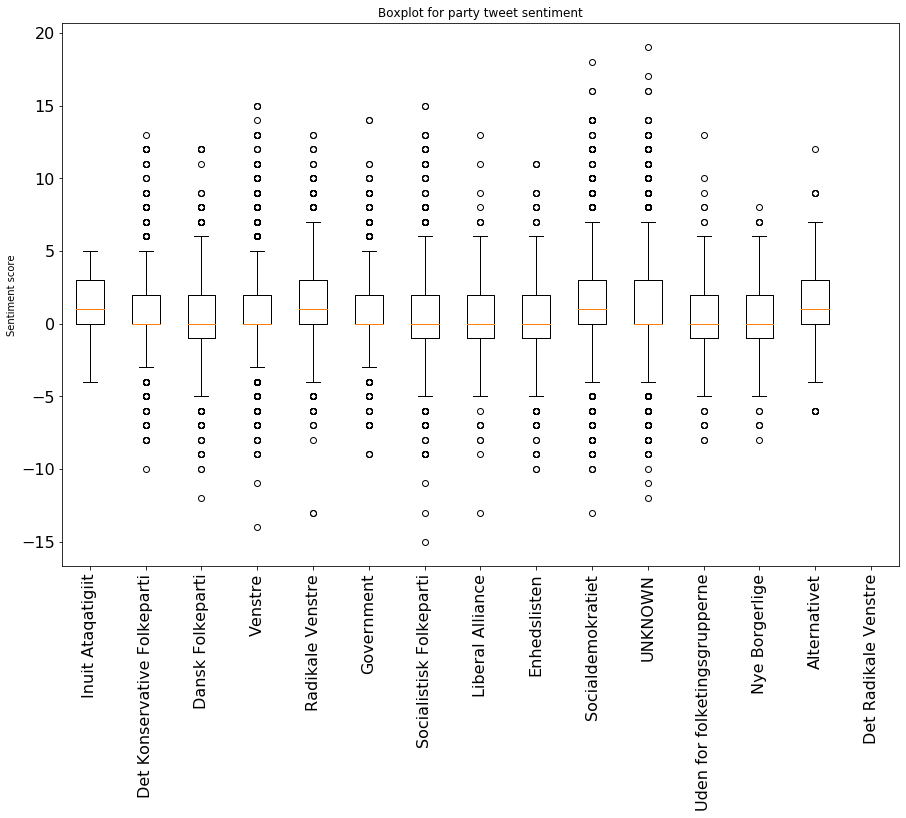

In [63]:
# for each party get statistics and make plot
box_labels = []
_scores = []

for key, value in total_sentiment.items():
    box_labels.append(key)
    score_l = []
    for inner in value.values():
        score = inner['scores']
        #print(score)
        score_l.extend(score)
    _scores.append(score_l)
print(len(_scores))
#The results are a bit mixed, we see dansk folkeparti agreeing the most with det konservative, and det konservative to venstre as these are all blue block members, however enhedslisten agrees most with Radikale, which is not the same block. Same thing can be said for Venstre -> Radikale and Liberal -> Radikale. This could suggest that the current block politic strategy might be a bit flawed. However it must also be considered that there are a lot of unknown parties so the truth could be burried in decrypting this data.

The results are a bit mixed, we see dansk folkeparti agreeing the most with det konservative, and det konservative to venstre as these are all blue block members, however enhedslisten agrees most with Radikale, which is not the same block. Same thing can be said for Venstre -> Radikale and Liberal -> Radikale. This could suggest that the current block politic strategy might be a bit flawed. However it must also be considered that there are a lot of unknown parties so the truth could be burried in decrypting this data.

print((_scores))

fig = plt.subplots(figsize=(15,10))
plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.ylabel('Sentiment score')
plt.title("Boxplot for party tweet sentiment")
plt.boxplot(_scores, labels=box_labels)
plt.show()



#### Plotting a relationship graph

100%|██████████| 2000/2000 [00:00<00:00, 26642.26it/s]


BarnesHut Approximation  took  0.02  seconds
Repulsion forces  took  0.04  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds
225


C:\Users\Christian\anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.


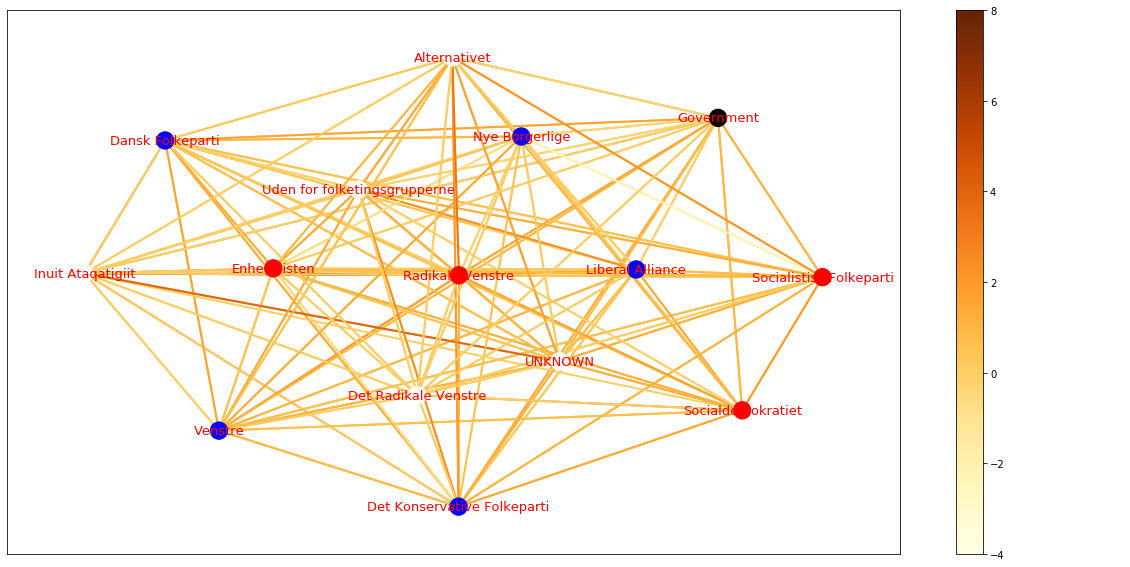

In [39]:
import matplotlib as mpl

G_friends =  G = nx.DiGraph()
# adding edges with weights according to sentiment 
for node in total_sentiment.keys():
    for _node in total_sentiment[node].keys():
        G.add_edge(node, _node)

plt.figure(figsize=(20,10))

pos = forceatlas2.forceatlas2_networkx_layout(G_friends, pos=None, iterations=2000)
M = G.number_of_edges()
print(M)

colors_friends = []

node_color_friends = []
for node in G.nodes():
    if node in blue_bloc:
        node_color_friends.append('blue')
    elif n#### Plotting a relationship graphode in red_bloc:
        node_color_friends.append('red')
    elif node == 'Government':
        node_color_friends.append('black')
    else:
        node_color_friends.append('white')

for key, val in total_sentiment.items():
    for score in val.values():
        colors_friends.append(score['mean']) 
nodes = nx.draw_networkx_nodes(G, pos=pos, with_labels = True, node_color=node_color_friends)
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=1,
    arrowstyle="->",
    arrowsize=10,
    edge_color=colors_friends,
    edge_cmap=plt.cm.YlOrBr,
    width=2,
)
labels = {}    
for node in G.nodes():
    labels[node] = node

nx.draw_networkx_labels(G,pos,labels,font_size=13,font_color='r')

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.YlOrBr)
pc.set_array(colors_friends)

plt.colorbar(pc)
ax = plt.gca(label='Score')
ax.set_axis_off()
plt.ylabel('Score')
plt.show()

In [40]:
len(colors_friends)

225